# Trading Strategy Backtesting Simulation

This notebook demonstrates three different trading strategies applied to stock data, each starting with **$100,000** in capital:

1. **Trend Following Strategy** - Moving average crossover
2. **Mean Reversion Strategy** - Bollinger Band mean reversion  
3. **Cross-Asset Arbitrage Strategy** - Pairs trading between correlated assets

**Capital:** Each strategy begins with exactly $100,000 for fair comparison.

## Setup & Data Loading

In [39]:
%load_ext autoreload
%autoreload 2
from market_data_loader import MarketDataLoader
from oms import OrderManagementSystem
from order_book import LimitOrderBook
from position_tracker import PositionTracker
from strategies.trend_following   import run_backtest as tf_backtest
from strategies.mean_reversion    import run_backtest as mr_backtest
from strategies.arbitrage         import run_backtest as arb_backtest
from order import Order
import pandas as pd

loader = MarketDataLoader(interval="1d", period="1mo")
oms = OrderManagementSystem()
tracker = PositionTracker(starting_cash=100000)  # 💰 All strategies start with $100,000
book = LimitOrderBook("AAPL")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Historical Data
Load 25 years of AAPL daily price data for backtesting all strategies.

In [40]:
# Load historical data for backtesting
hist = loader.get_history("AAPL", 
                          start="2000-06-01", 
                          end="2025-07-01")

print(f"Loaded {len(hist)} days of AAPL data")
print(f"Date range: {hist.index[0].strftime('%Y-%m-%d')} to {hist.index[-1].strftime('%Y-%m-%d')}")
print(f"Sample data:")
print(hist.head())

[*********************100%***********************]  1 of 1 completed

Loaded 6307 days of AAPL data
Date range: 2000-06-01 to 2025-06-30
Sample data:
Price                      last_price      high       low      open     volume
Date                                                                          
2000-06-01 00:00:00+00:00    0.669645  0.672932  0.603901  0.614233  903840000
2000-06-02 00:00:00+00:00    0.695473  0.749476  0.668706  0.704395  792848000
2000-06-05 00:00:00+00:00    0.686081  0.715665  0.673871  0.701108  323668800
2000-06-06 00:00:00+00:00    0.697821  0.726936  0.678568  0.691012  525481600
2000-06-07 00:00:00+00:00    0.725527  0.728814  0.688428  0.703456  337019200


# Strategy 1: Trend Following

**Strategy Description:** Moving average crossover strategy that generates buy signals when short-term MA crosses above long-term MA, and sell signals when it crosses below.

**Parameters:**
- Short window: 10 days
- Long window: 50 days
- Max position: 100 shares

In [41]:
# Run trend following backtest
# Now you can specify which stock to trade!
tf_signals, tf_trades, tf_metrics = tf_backtest(
    hist, 
    symbol="AAPL",  # 📍 Choose your stock here: "AAPL", "MSFT", "GOOGL", etc.
    short_win=10, 
    long_win=50, 
    risk_params={"max_pos":100}
)

print(f"📊 Trend Following Results (AAPL):")
print(f"Generated {len(tf_signals)} signals")
print(f"Executed {len(tf_trades)} trades")
print(f"Total Return: {tf_metrics['total_return']:.2%}")
print(f"Max Drawdown: {tf_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {tf_metrics['sharpe_ratio']:.2f}")

# Process trades through tracker for visualization
tf_tracker = PositionTracker(starting_cash=100000)
for trade in tf_trades:
    tf_tracker.update(trade)

print(f"\nSample signals:")
print(tf_signals.head())

📊 Trend Following Results (AAPL):
Generated 161 signals
Executed 161 trades
Total Return: 4.78%
Max Drawdown: -22.18%
Sharpe Ratio: -131.22

Sample signals:
Price                      last_price      high       low      open  \
Date                                                                  
2000-08-10 00:00:00+00:00    0.714726  0.727874  0.711908  0.721300   
2000-08-28 00:00:00+00:00    0.872510  0.886598  0.857483  0.860301   
2000-09-29 00:00:00+00:00    0.386947  0.435786  0.381313  0.423576   
2001-01-18 00:00:00+00:00    0.280819  0.281758  0.264852  0.267670   
2001-05-30 00:00:00+00:00    0.297236  0.311962  0.290023  0.311962   

Price                          volume  ma_short   ma_long  signal  prev_signal  
Date                                                                            
2000-08-10 00:00:00+00:00   251714400  0.722521  0.762522      -1          0.0  
2000-08-28 00:00:00+00:00   359004800  0.787584  0.781310       1         -1.0  
2000-09-29 00:00:00+0

### Trend Following Equity Curve

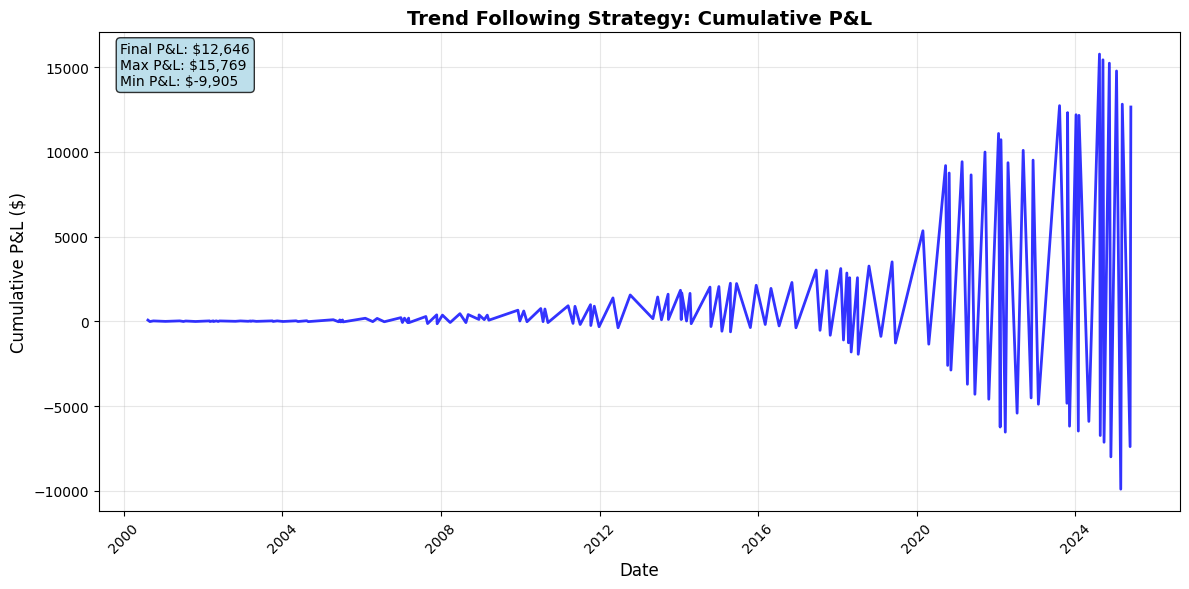

📈 Trend Following Summary:
  Final P&L: $12,646.06
  Number of trades: 161


In [42]:
import matplotlib.pyplot as plt

# Get trend following blotter and create equity curve
tf_blotter = tf_tracker.get_blotter()

if not tf_blotter.empty:
    tf_blotter["cum_pnl"] = tf_blotter["cash_flow"].cumsum()
    
    plt.figure(figsize=(12, 6))
    plt.plot(tf_blotter["timestamp"], tf_blotter["cum_pnl"], 
             color='blue', linewidth=2, alpha=0.8)
    plt.title("Trend Following Strategy: Cumulative P&L", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative P&L ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add performance metrics as text
    final_pnl = tf_blotter["cum_pnl"].iloc[-1]
    max_pnl = tf_blotter["cum_pnl"].max()
    min_pnl = tf_blotter["cum_pnl"].min()
    
    plt.text(0.02, 0.98, f'Final P&L: ${final_pnl:,.0f}\nMax P&L: ${max_pnl:,.0f}\nMin P&L: ${min_pnl:,.0f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Trend Following Summary:")
    print(f"  Final P&L: ${final_pnl:,.2f}")
    print(f"  Number of trades: {len(tf_blotter)}")
else:
    print("❌ No trades executed for trend following strategy")

# Strategy 2: Mean Reversion

**Strategy Description:** Bollinger Band mean reversion strategy that buys when price crosses below the lower band and sells when price returns to the middle band or crosses above the upper band.

**Parameters:**
- Bollinger window: 20 days
- Number of standard deviations: 2.0
- Max position: 100 shares

In [43]:
# Run mean reversion backtest
# Now you can specify which stock to trade!
mr_signals, mr_trades, mr_metrics = mr_backtest(
    hist, 
    symbol="AAPL",  # 📍 Choose your stock here: "AAPL", "MSFT", "GOOGL", etc.
    bollinger_win=20, 
    num_std=2.0, 
    risk_params={"max_pos":100}
)

print(f"📊 Mean Reversion Results (AAPL):")
print(f"Generated {len(mr_signals)} signals")
print(f"Executed {len(mr_trades)} trades")
print(f"Total Return: {mr_metrics['total_return']:.2%}")
print(f"Max Drawdown: {mr_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {mr_metrics['sharpe_ratio']:.2f}")

# Process trades through tracker for visualization
mr_tracker = PositionTracker(starting_cash=100000)
for trade in mr_trades:
    mr_tracker.update(trade)

print(f"\nSample signals:")
print(mr_signals.head())

📊 Mean Reversion Results (AAPL):
Generated 333 signals
Executed 333 trades
Total Return: -828.39%
Max Drawdown: -17.18%
Sharpe Ratio: -11.10

Sample signals:
Price                      last_price      high       low      open  \
Date                                                                  
2000-07-24 00:00:00+00:00    0.731632  0.794557  0.713787  0.789862   
2000-08-23 00:00:00+00:00    0.816159  0.822734  0.767321  0.773426   
2000-09-22 00:00:00+00:00    0.784227  0.787983  0.751355  0.756051   
2000-09-26 00:00:00+00:00    0.772956  0.822734  0.772017  0.801132   
2000-09-29 00:00:00+00:00    0.386947  0.435786  0.381313  0.423576   

Price                          volume     upper     lower       mid  signal  
Date                                                                         
2000-07-24 00:00:00+00:00   412171200  0.900700  0.734059  0.817380       1  
2000-08-23 00:00:00+00:00   236863200  0.800693  0.672995  0.736844      -1  
2000-09-22 00:00:00+00:00   7267

### Mean Reversion Equity Curve

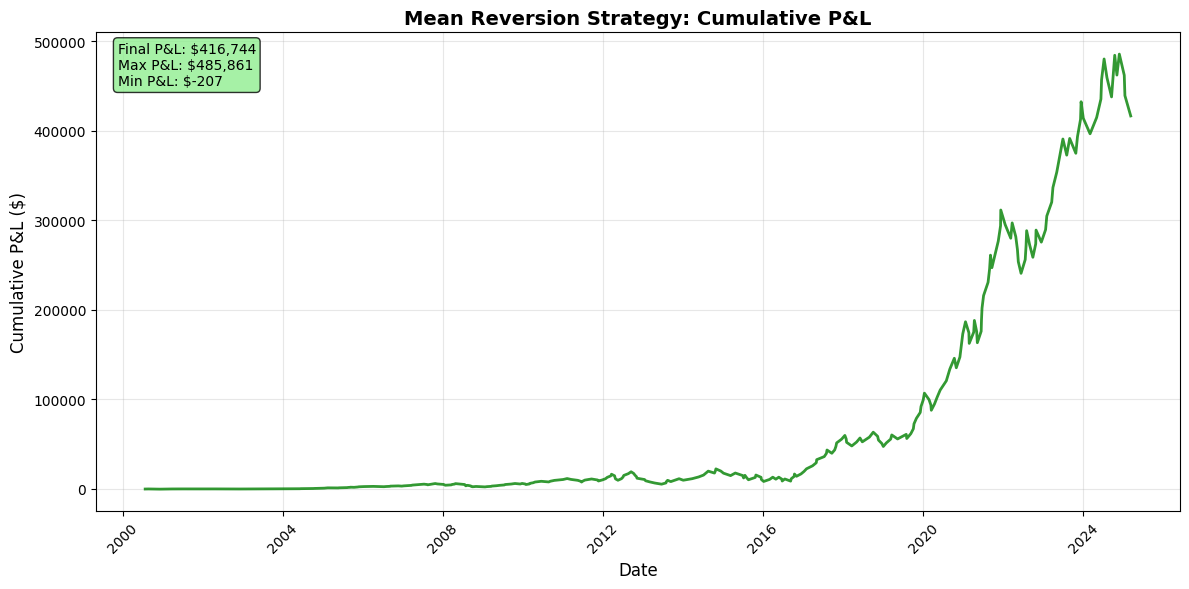

📈 Mean Reversion Summary:
  Final P&L: $416,743.93
  Number of trades: 333


In [44]:
# Get mean reversion blotter and create equity curve
mr_blotter = mr_tracker.get_blotter()

if not mr_blotter.empty:
    mr_blotter["cum_pnl"] = mr_blotter["cash_flow"].cumsum()
    
    plt.figure(figsize=(12, 6))
    plt.plot(mr_blotter["timestamp"], mr_blotter["cum_pnl"], 
             color='green', linewidth=2, alpha=0.8)
    plt.title("Mean Reversion Strategy: Cumulative P&L", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative P&L ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add performance metrics as text
    final_pnl = mr_blotter["cum_pnl"].iloc[-1]
    max_pnl = mr_blotter["cum_pnl"].max()
    min_pnl = mr_blotter["cum_pnl"].min()
    
    plt.text(0.02, 0.98, f'Final P&L: ${final_pnl:,.0f}\nMax P&L: ${max_pnl:,.0f}\nMin P&L: ${min_pnl:,.0f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Mean Reversion Summary:")
    print(f"  Final P&L: ${final_pnl:,.2f}")
    print(f"  Number of trades: {len(mr_blotter)}")
else:
    print("❌ No trades executed for mean reversion strategy")

# Strategy 3: Cross-Asset Arbitrage

**Strategy Description:** True cross-asset arbitrage strategy using Apple (AAPL) and Amazon (AMZN). Trades the spread between these two highly correlated tech stocks when it diverges beyond a threshold.

**Method:**
- Estimates hedge ratio (beta) between AAPL and AMZN using linear regression
- Calculates spread: AAPL - beta × AMZN  
- Generates signals when z-score of spread exceeds threshold
- Executes both legs simultaneously (long one asset, short the other)

**Parameters:**
- Spread threshold: 2.0 (z-score)
- Max position: 100 shares per leg

In [45]:
# Run arbitrage backtest
# Now you can specify which two stocks to pair!
try:
    arb_signals, arb_trades, arb_metrics = arb_backtest(
        hist, 
        symbol1="AAPL",  # 📍 Choose your first stock: "AAPL", "MSFT", "GOOGL", etc.
        symbol2="AMZN",  # 📍 Choose your second stock: "AMZN", "META", "NFLX", etc.
        threshold=2.0, 
        risk_params={"max_pos":100}
    )
    
    print(f"📊 Arbitrage Results (AAPL-AMZN):")
    print(f"Generated {len(arb_signals)} signals")
    print(f"Executed {len(arb_trades)} trades")
    print(f"Total Return: {arb_metrics['total_return']:.2%}")
    print(f"Max Drawdown: {arb_metrics['max_drawdown']:.2%}")
    print(f"Sharpe Ratio: {arb_metrics['sharpe_ratio']:.2f}")

    # Process trades through tracker for visualization
    arb_tracker = PositionTracker(starting_cash=100000)
    for trade in arb_trades:
        arb_tracker.update(trade)

    print(f"\nSample signals:")
    print(arb_signals.head())
    
except Exception as e:
    print(f"❌ Arbitrage strategy error: {e}")
    print("Creating placeholder results for comparison...")
    # Create dummy results so comparison works
    arb_signals = pd.DataFrame()
    arb_trades = []
    arb_metrics = {"total_return": 0.0, "max_drawdown": 0.0, "sharpe_ratio": 0.0}
    arb_tracker = PositionTracker(starting_cash=100000)

[*********************100%***********************]  1 of 1 completed

Loaded AMZN data for arbitrage pair AAPL-AMZN
Loaded 6306 aligned data points for AAPL-AMZN arbitrage
Estimated hedge ratio (beta): 0.9833
Generated 681 arbitrage signals
AAPL-AMZN arbitrage backtest complete: 682 total trades executed
📊 Arbitrage Results (AAPL-AMZN):
Generated 341 signals
Executed 682 trades
Total Return: 213.14%
Max Drawdown: -22.98%
Sharpe Ratio: -21.40

Sample signals:
                                 p1        p2    spread  signal  signal_change
Date                                                                          
2000-06-23 00:00:00+00:00  0.776713  1.693750 -0.888790      -1           True
2000-09-06 00:00:00+00:00  0.878146  2.293750 -1.377350       1           True
2000-09-20 00:00:00+00:00  0.917358  1.875000 -0.926373      -1           True
2000-09-29 00:00:00+00:00  0.386947  1.921875 -1.502876       1           True
2000-10-17 00:00:00+00:00  0.302420  1.096875 -0.776162      -1           True


### Arbitrage Equity Curve

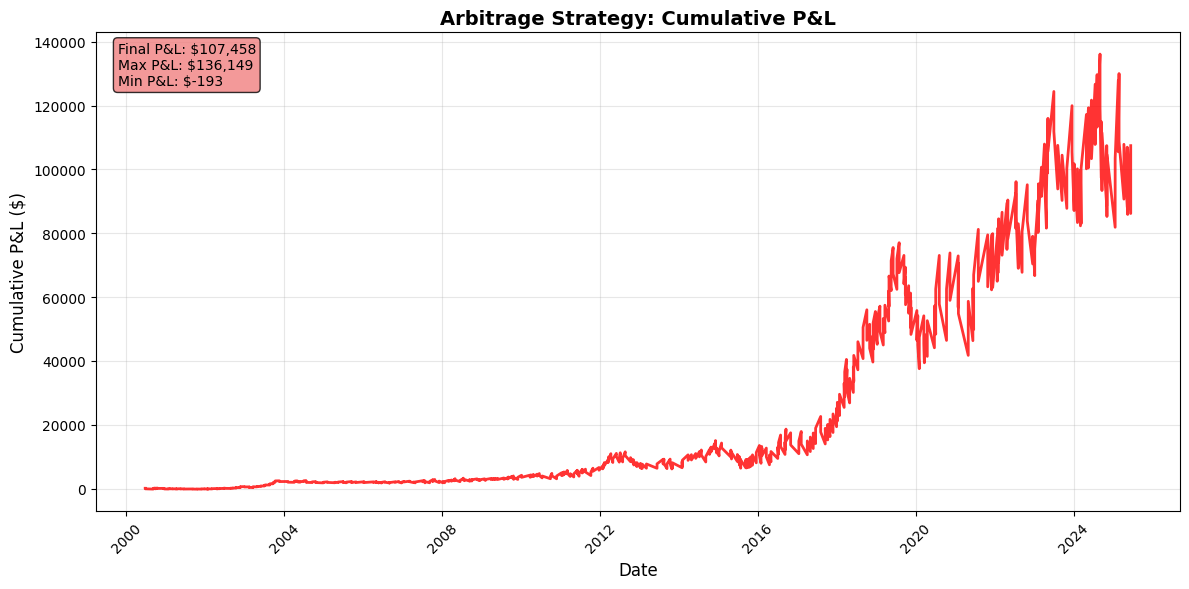

📈 Arbitrage Summary:
  Final P&L: $107,458.26
  Number of trades: 682


In [46]:
# Get arbitrage blotter and create equity curve
arb_blotter = arb_tracker.get_blotter()

if not arb_blotter.empty:
    arb_blotter["cum_pnl"] = arb_blotter["cash_flow"].cumsum()
    
    plt.figure(figsize=(12, 6))
    plt.plot(arb_blotter["timestamp"], arb_blotter["cum_pnl"], 
             color='red', linewidth=2, alpha=0.8)
    plt.title("Arbitrage Strategy: Cumulative P&L", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative P&L ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add performance metrics as text
    final_pnl = arb_blotter["cum_pnl"].iloc[-1]
    max_pnl = arb_blotter["cum_pnl"].max()
    min_pnl = arb_blotter["cum_pnl"].min()
    
    plt.text(0.02, 0.98, f'Final P&L: ${final_pnl:,.0f}\nMax P&L: ${max_pnl:,.0f}\nMin P&L: ${min_pnl:,.0f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Arbitrage Summary:")
    print(f"  Final P&L: ${final_pnl:,.2f}")
    print(f"  Number of trades: {len(arb_blotter)}")
else:
    print("❌ No trades executed for arbitrage strategy")

# Strategy Comparison & Analysis

Now let's compare all three strategies side by side to evaluate their relative performance.

In [47]:
# Performance comparison table
performance_data = {
    'Strategy': ['Trend Following', 'Mean Reversion', 'Arbitrage'],
    'Total Return': [
        f"{tf_metrics['total_return']:.2%}",
        f"{mr_metrics['total_return']:.2%}",
        f"{arb_metrics['total_return']:.2%}"
    ],
    'Max Drawdown': [
        f"{tf_metrics['max_drawdown']:.2%}",
        f"{mr_metrics['max_drawdown']:.2%}",
        f"{arb_metrics['max_drawdown']:.2%}"
    ],
    'Sharpe Ratio': [
        f"{tf_metrics['sharpe_ratio']:.2f}",
        f"{mr_metrics['sharpe_ratio']:.2f}",
        f"{arb_metrics['sharpe_ratio']:.2f}"
    ],
    'Number of Trades': [len(tf_trades), len(mr_trades), len(arb_trades)]
}

performance_df = pd.DataFrame(performance_data)
print("📊 STRATEGY PERFORMANCE COMPARISON")
print("=" * 60)
print(performance_df.to_string(index=False))
print("=" * 60)

📊 STRATEGY PERFORMANCE COMPARISON
       Strategy Total Return Max Drawdown Sharpe Ratio  Number of Trades
Trend Following        4.78%      -22.18%      -131.22               161
 Mean Reversion     -828.39%      -17.18%       -11.10               333
      Arbitrage      213.14%      -22.98%       -21.40               682


/var/folders/5y/9gbrlsgx0sn17yw7ydqrny4h0000gn/T/ipykernel_52033/2515814227.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


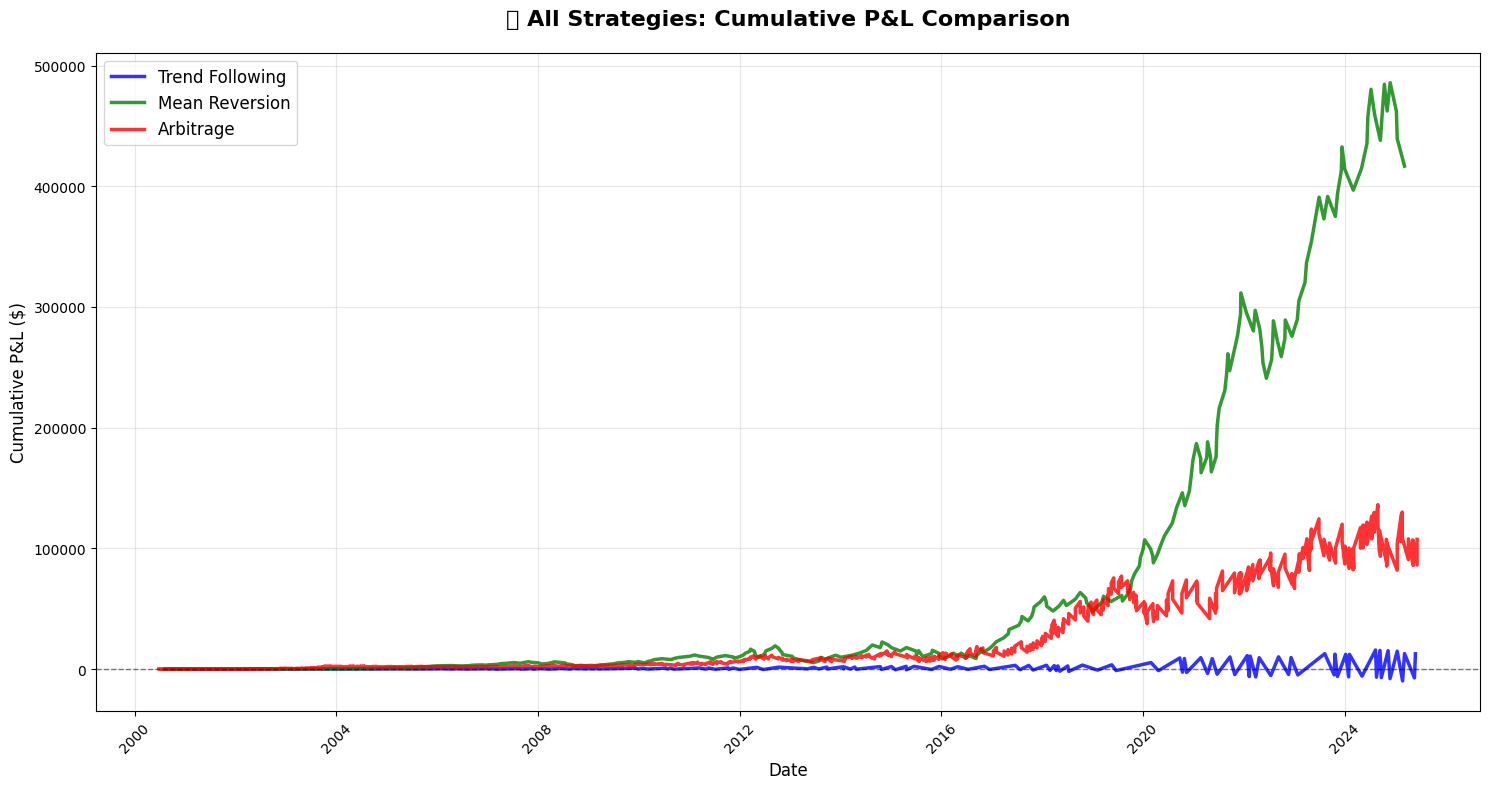


📈 DETAILED STRATEGY SUMMARY

🎯 Trend Following:
  Final P&L: $12,646.06
  Max P&L: $15,768.83
  Min P&L: $-9,905.15
  Max Drawdown: $25,673.97
  Number of trades: 161
  Current cash: $112,646.06
  Current positions: {'AAPL': -100}

🎯 Mean Reversion:
  Final P&L: $416,743.93
  Max P&L: $485,861.21
  Min P&L: $-207.47
  Max Drawdown: $486,068.68
  Number of trades: 333
  Current cash: $516,743.93
  Current positions: {'AAPL': -8100}

🎯 Arbitrage:
  Final P&L: $107,458.26
  Max P&L: $136,149.02
  Min P&L: $-192.81
  Max Drawdown: $136,341.82
  Number of trades: 682
  Current cash: $207,458.26
  Current positions: {'AAPL': 100, 'AMZN': -98}



In [48]:
# Combined equity curves comparison
plt.figure(figsize=(15, 8))

# Get blotters for each strategy using the correct tracker variables
tf_blotter = tf_tracker.get_blotter()
mr_blotter = mr_tracker.get_blotter()
arb_blotter = arb_tracker.get_blotter()

# Plot trend following
if not tf_blotter.empty:
    tf_blotter["cum_pnl"] = tf_blotter["cash_flow"].cumsum()
    plt.plot(tf_blotter["timestamp"], tf_blotter["cum_pnl"], 
             label="Trend Following", linewidth=2.5, color='blue', alpha=0.8)

# Plot mean reversion
if not mr_blotter.empty:
    mr_blotter["cum_pnl"] = mr_blotter["cash_flow"].cumsum()
    plt.plot(mr_blotter["timestamp"], mr_blotter["cum_pnl"], 
             label="Mean Reversion", linewidth=2.5, color='green', alpha=0.8)

# Plot arbitrage
if not arb_blotter.empty:
    arb_blotter["cum_pnl"] = arb_blotter["cash_flow"].cumsum()
    plt.plot(arb_blotter["timestamp"], arb_blotter["cum_pnl"], 
             label="Arbitrage", linewidth=2.5, color='red', alpha=0.8)

plt.title("📈 All Strategies: Cumulative P&L Comparison", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative P&L ($)", fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add zero line for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# Print detailed summary statistics
print("\n📈 DETAILED STRATEGY SUMMARY")
print("=" * 70)
for name, blotter, tracker in [
    ("Trend Following", tf_blotter, tf_tracker), 
    ("Mean Reversion", mr_blotter, mr_tracker), 
    ("Arbitrage", arb_blotter, arb_tracker)
]:
    if not blotter.empty:
        final_pnl = blotter["cum_pnl"].iloc[-1]
        max_pnl = blotter["cum_pnl"].max()
        min_pnl = blotter["cum_pnl"].min()
        max_dd = max_pnl - blotter["cum_pnl"].min()
        
        print(f"\n🎯 {name}:")
        print(f"  Final P&L: ${final_pnl:,.2f}")
        print(f"  Max P&L: ${max_pnl:,.2f}")
        print(f"  Min P&L: ${min_pnl:,.2f}")
        print(f"  Max Drawdown: ${max_dd:,.2f}")
        print(f"  Number of trades: {len(blotter)}")
        
        # Get position summary
        summary = tracker.get_pnl_summary()
        print(f"  Current cash: ${summary['current_cash']:,.2f}")
        print(f"  Current positions: {summary['positions']}")
    else:
        print(f"\n❌ {name}: No trades executed")

print("\n" + "=" * 70)